# Modelos de Machine Learning 

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from time import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer

from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
import joblib


from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix

from gensim.models import Word2Vec


## Importamos el Dataset

In [45]:
df_lem = pd.read_csv('../../cyberbullying/data/classified_racism_tweets.csv')
df_lem.head()

,text,target
0,rt beepss senna beepss i m not sexist but fuck...,gender
1,no you don t shut up jeff i thought of a reall...,gender
2,rt wateronatrain mt you might like this http t...,gender
3,rt metalbarbiedoll but yea apparently gamergat...,gender
4,d nkrause dudes who go to culinary school why ...,gender


In [46]:
df_lem.shape

(42447, 2)

In [47]:
percentage_used = 1
df_sample = df_lem.sample(frac=percentage_used, random_state=0)

In [48]:
from sklearn.preprocessing import LabelEncoder
label_enc=LabelEncoder()
df_sample['encoded_target']=label_enc.fit_transform(df_sample['target'])


In [49]:
df_sample

,text,target,encoded_target
29372,it s so freaking embarrassing that the preside...,age,0
12887,i am salafi yrs i taken ilm from spubs don t e...,religion,4
21829,what i took from all of this is that wadhwa do...,other_cyberbullying,3
40140,yourhighaj kursory momozoned hahahaha fuck you...,ethnicity,1
32750,like a tiny portion of dudes ever experience t...,age,0
...,...,...,...
41993,my brother get the fuck on my nerves dumb as n...,ethnicity,1
32103,transphobes get the bullet transphobic bullies...,age,0
30403,damn dude you really seem to dislike ghost of ...,age,0
21243,dylanw also totes constructive mention there i...,other_cyberbullying,3


In [50]:
class_labels=label_enc.classes_
class_labels

array(['age', 'ethnicity', 'gender', 'other_cyberbullying', 'religion'],
      dtype=object)

In [51]:
df_sample['encoded_target'].value_counts()

1    9873
2    8841
4    7982
0    7956
3    7795
Name: encoded_target, dtype: int64

## Holdout

In [52]:
X_train, X_test, y_train, y_test = train_test_split(df_sample['text'], df_sample['encoded_target'], test_size=0.3, random_state=0)

In [53]:
X_train

629             mkr the sassy girls having a blonde moment
26870    in my school the pe teachers were mostly paedo...
16783    muslims ain t terrorist but b cos of an openin...
86       rt ohsosoftley some of you people will call me...
20290    danielzklein everytime he tells me about how q...
                               ...                        
27362    i m an anomaly because i m a lesbian and came ...
38611    http via me pvezng rt cleon tayyoung fuck obam...
17618    if i remember correctly muslims once ruled ove...
39821    xbonetourneys gatz games why cant i v dumb nig...
37362    lmaoo rt goats cup bet you ve sucked hella nig...
Name: text, Length: 29712, dtype: object

In [23]:
def balance_df(X, y, ratio=0.3):
    df = pd.DataFrame({'text': X, 'target': y})
    df_class_0 = df[df['target'] == 0]
    df_class_1 = df[df['target'] == 1]
    df_class_1_len = df_class_1.shape[0]
    
    df_class_0_new = df_class_0.sample(int(df_class_1_len * (1-ratio)/ratio))
    df_new = pd.concat([df_class_0_new, df_class_1]).sample(frac=1).reset_index(drop=True)
    
    X = df_new['text']
    y = df_new['target']

    return X, y

#X_train, y_train = balance_df(X_train, y_train, ratio=0.1)
# no lo usamos

In [24]:
scoring = ['accuracy', 'precision', 'recall', 'f1']
scorer = make_scorer(f1_score)

In [25]:
def scores(cv_results):
    score_results = {'accuracy': None, 'precision': None, 'recall': None, 'f1': None, 'time': None}
    for key in score_results.keys():
        if key == 'time':
            score_results[key] = round(cv_results['fit_time'].mean() + cv_results['score_time'].mean(), 1)
        else:
            score_results[key] = round(cv_results[f'test_{key}'].mean(), 4)
    return score_results

In [26]:
def conf_mx_all(y_test, y_pred):
    
    cm = confusion_matrix(y_test, y_pred)
    
    TN = cm[0,0]
    TP = cm[1,1]
    FN = cm[1,0]
    FP = cm[0,1]
    
    recall = np.round_(TP/(TP+FN),3)
    precision = np.round_(TP/(TP+FP),3)
    accuracy = np.round_((TP+TN)/(TP+TN+FP+FN),3)
    F1= np.round((2*precision*recall)/(precision+recall), 3)
    
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"Accuracy: {accuracy}")
    print(f"F1-score: {F1}")
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1])
    disp.plot();
    
    return recall, precision, accuracy, F1

In [27]:
def pipeline(vectorizer_list, learner_list, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    def list_params(new_class):
        name = new_class.__class__.__name__
        default_class = eval(name + '()').get_params()
        new_class = new_class.get_params()

        new_dict = {}

        for key in new_class.keys():
            if new_class[key] != default_class[key]:
                new_dict[key] = new_class[key]
        return new_dict
    
    
    # Get length of Training Data:
    size = len(y_train)
    
    results = {}
    final_results = []
    
    for vectorizer in vectorizer_list:
        
        X_train_vec = vectorizer.fit_transform(X_train)
        X_test_vec = vectorizer.transform(X_test)
        
    
        for learner in learner_list:
        
            # Store the learner name:
            results['Algorithm'] = learner.__class__.__name__

            # Fit the learner:
            start = time() # Get start time
            print("Training {}".format(learner.__class__.__name__))
            learner = learner.fit(X_train_vec, y_train)
            end = time() # Get end time

            # Store the training time
            results['Training Time'] = end - start

            start = time() # Get start time
            predictions_test = learner.predict(X_test_vec)
            predictions_train = learner.predict(X_train_vec)
            end = time() # Get end time

            # Store the prediction time
            results['Prediction Time'] = end - start

            results['Metrics: Test']=classification_report(y_test, predictions_test, target_names=label_enc.classes_)
            results['Metrics: Train']=classification_report(y_train, predictions_train, target_names=label_enc.classes_)

            # Compute the Accuracy on Test Set
            #results['Accuracy: Test'] = accuracy_score(y_test, predictions_test)

            # Compute the Accuracy on Training Set
            #results['Accuracy: Train'] = accuracy_score(y_train, predictions_train)

            # Compute the F1 Score on Test Set
            #results['F1 Score: Test'] = f1_score(y_test, predictions_test)

            # Compute the F1 Score on Training Set
            #results['F1 Score: Train'] = f1_score(y_train, predictions_train)

            # Compute the Precision on Test Set
            #results['Precision: Test'] = precision_score(y_test, predictions_test)

            # Compute the Precision on Training Set
            #results['Precision: Train'] = precision_score(y_train, predictions_train)

            # Compute the Recall on Test Set
            #results['Recall: Test'] = recall_score(y_test, predictions_test)

            # Compute the Recall on Training Set
            #results['Recall: Train'] = recall_score(y_train, predictions_train)

            # Success
            print("Training {} finished in {:.2f} sec".format(learner.__class__.__name__, results['Training Time']))
            print('----------------------------------------------------')

            final_results.append(results.copy())
    # Return a dataframe of the results
    return final_results


In [10]:
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier



In [71]:
%%time
# make a list of vectorizers
vectorizers = [TfidfVectorizer(min_df=10, max_df=0.8, max_features=20000, ngram_range=(1,2))]

# make a list of models
models = [AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),
                               n_estimators=10),XGBClassifier(max_depth=10, n_estimators=100, learning_rate=0.1)] 


re = pipeline(vectorizers, models, X_train, y_train, X_test, y_test)
results = pd.DataFrame(re)

Training AdaBoostClassifier
Training AdaBoostClassifier finished in 4.10 sec
----------------------------------------------------
Training XGBClassifier


/home/valengou/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:58:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training XGBClassifier finished in 221.89 sec
----------------------------------------------------
CPU times: user 14min 37s, sys: 10.4 s, total: 14min 47s
Wall time: 3min 52s


In [72]:
results['Algorithm']

0    AdaBoostClassifier
1         XGBClassifier
Name: Algorithm, dtype: object

In [73]:
results['Metrics: Test'][0]

'                     precision    recall  f1-score   support\n\n                age       0.99      0.98      0.98      2419\n          ethnicity       0.97      0.97      0.97      2362\n             gender       0.94      0.60      0.73      2373\nother_cyberbullying       0.61      0.93      0.73      2314\n             racism       0.51      0.49      0.50       607\n           religion       0.93      0.79      0.85      2390\n             sexism       0.53      0.55      0.54      1006\n\n           accuracy                           0.81     13471\n          macro avg       0.78      0.76      0.76     13471\n       weighted avg       0.84      0.81      0.82     13471\n'

In [74]:
results['Metrics: Test'][1]

'                     precision    recall  f1-score   support\n\n                age       0.99      0.99      0.99      2419\n          ethnicity       1.00      0.99      0.99      2362\n             gender       0.77      0.64      0.70      2373\nother_cyberbullying       0.75      0.94      0.83      2314\n             racism       0.26      0.22      0.24       607\n           religion       0.84      0.79      0.81      2390\n             sexism       0.37      0.38      0.38      1006\n\n           accuracy                           0.80     13471\n          macro avg       0.71      0.71      0.71     13471\n       weighted avg       0.80      0.80      0.80     13471\n'

## Word2vec

In [74]:
word2vec = Word2Vec(sentences=X_train, vector_size=32, window=5, min_count=5) # jupyter

In [75]:
def embed_sentence(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec.wv:
            embedded_sentence.append(word2vec.wv[word])
        
    return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed

# Embed the training and test sentences
#X_train_embed = embedding(word2vec, X_train)
#X_test_embed = embedding(word2vec, X_test)

In [77]:
#X_train_embed

[array([[-0.2172578 , -0.9865016 , -0.9825889 , ...,  0.7212194 ,
         -1.0420656 , -0.06421635],
        [ 0.14701545,  0.35241413, -0.27445495, ...,  0.90700483,
          0.15027344, -0.05250748],
        [-0.18218821,  0.5232746 , -0.33060643, ..., -0.58168995,
          0.32695988,  0.12227676],
        ...,
        [ 0.18125896, -0.31676418,  0.5225933 , ...,  0.5240189 ,
          0.34141675, -0.2639442 ],
        [ 0.14701545,  0.35241413, -0.27445495, ...,  0.90700483,
          0.15027344, -0.05250748],
        [ 0.13529386, -0.24268274,  0.10489482, ...,  1.0016974 ,
          0.38755438, -0.4399756 ]], dtype=float32),
 array([[-0.18218821,  0.5232746 , -0.33060643, ..., -0.58168995,
          0.32695988,  0.12227676],
        [-0.08063355,  0.27025348, -0.6822836 , ...,  0.39196625,
          0.5615092 ,  0.34392542],
        [-0.18218821,  0.5232746 , -0.33060643, ..., -0.58168995,
          0.32695988,  0.12227676],
        ...,
        [ 0.4214652 ,  0.6446021 , -0.0

In [79]:
y_train

5492     2
18158    5
4880     4
33518    0
7763     2
        ..
13554    5
30255    0
40798    1
945      6
14294    5
Name: encoded_target, Length: 31432, dtype: int64

model=AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),n_estimators=10)

#model.fit(X_train_embed, y_train)


predictions_test = model.predict(X_test_embed)
predictions_train = model.predict(X_train_embed)


results_test=classification_report(y_test, predictions_test, target_names=label_enc.classes_)
results_train=classification_report(y_train, predictions_train, target_names=label_enc.classes_)


In [143]:
def get_best_model(model, type_):
    name = model[type_]
    params = model[f'{type_} Params']
    return eval(f'{name}(**{params})')

In [144]:
best_vectorizer = get_best_model(results.iloc[0], 'Vectorizer')
best_model = get_best_model(results.iloc[0], 'Algorithm')

In [145]:
best_vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=20000,
                min_df=3, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [146]:
best_model

LinearSVC(C=1.0, class_weight={0: 0.1, 1: 0.9}, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [19]:
def plot_scores(results):
    score_results = {'class_weight': [dic['class_weight'][0] for dic in results['Algorithm Params'].values],
                     'accuracy': results['accuracy'],
                     'precision': results['precision'],
                     'recall': results['recall'],
                     'f1': results['f1'],
                     'time': results['Training Time'] + results['Prediction Time']}
    
    score_results = pd.DataFrame(data=score_results).sort_values(by = 'class_weight').reset_index(drop = True)
    
    plt.figure(figsize=(12,6))
        
    plt.plot(score_results['class_weight'], score_results['recall'], c='r', label='recall')
    plt.plot(score_results['class_weight'], score_results['precision'], c='b', label='precision')    
    plt.plot(score_results['class_weight'], score_results['f1'], c='g', label='f1')
    plt.xlabel('class weight')
    plt.ylabel('score')
    plt.legend()
    plt.grid(alpha=0.3)
        
    #return score_results

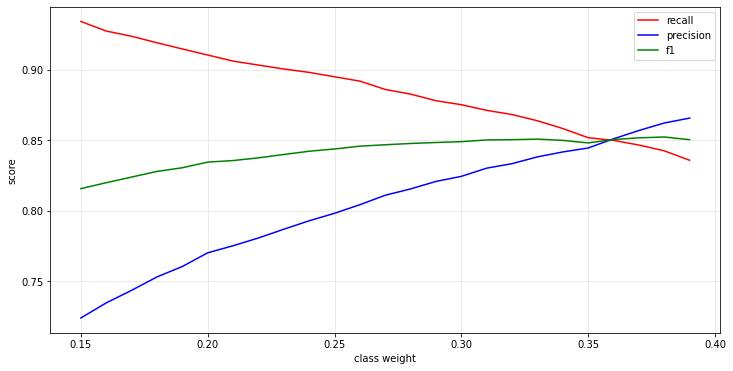

In [20]:
plot_scores(results)

In [21]:
vectorizer = best_vectorizer
model = best_model

In [22]:
preprocessing = make_column_transformer(
    (make_pipeline(vectorizer), 'text')
)

In [23]:
pipe = make_pipeline(
    preprocessing,
    model
)

pipe

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline',
                                                  Pipeline(memory=None,
                                                           steps=[('tfidfvectorizer',
                                                                   TfidfVectorizer(analyzer='word',
                                                                                   binary=False,
                                                                                   decode_error='strict',
                                                                                   dtype=<class 'numpy.float64'>,
                                                                                   encoding='utf-8',
                  

In [24]:
pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                     transformer_weights=None,
                     transformers=[('pipeline',
                                    Pipeline(memory=None,
                                             steps=[('tfidfvectorizer',
                                                     TfidfVectorizer(analyzer='word',
                                                                     binary=False,
                                                                     decode_error='strict',
                                                                     dtype=<class 'numpy.float64'>,
                                                                     encoding='utf-8',
                                                                     input='content',
                                                                     lowercase=True,
                                

In [25]:
#X_train = pd.DataFrame(data=X_train, columns=['text'])
#X_test = pd.DataFrame(data=X_test, columns=['text'])

In [26]:
cv_results = cross_validate(pipe, X_train, y_train, cv=5, n_jobs=-1, scoring=scoring)

In [27]:
scores(cv_results)

{'accuracy': 0.9183,
 'precision': 0.8392,
 'recall': 0.8093,
 'f1': 0.8239,
 'time': 1.2}

In [28]:
pipe.fit(X_train, y_train);

In [29]:
y_pred = pipe.predict(X_test)

Recall: 0.843
Precision: 0.862
Accuracy: 0.93
F1-score: 0.852


(0.843, 0.862, 0.93, 0.852)

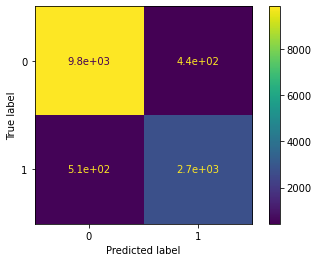

In [30]:
conf_mx_all(y_test, y_pred)

In [31]:
params = {
    'columntransformer__pipeline__tfidfvectorizer__min_df': np.arange(5, 11),
    'linearsvc__C': np.arange(0.8, 1.3, 0.1),
    'linearsvc__class_weight': [{0: weight_0, 1: 1-weight_0} for weight_0 in np.arange(0.17, 0.24, 0.01)]
    
}

In [32]:
params = {
    'columntransformer__pipeline__tfidfvectorizer__min_df': np.arange(5, 11),
    'linearsvc__C': np.arange(0.9, 1.2, 0.1),
    'linearsvc__class_weight': [{0: weight_0, 1: 1-weight_0} for weight_0 in np.arange(0.18, 0.24, 0.01)],
    'linearsvc__dual': [False]
}

In [33]:
search = GridSearchCV(pipe, param_grid=params, cv=5, n_jobs=-1, scoring='f1')

In [34]:
%%time
#search.fit(X_train, y_train)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 31.9 µs


In [35]:
#search.best_params_

In [36]:
#best_estimator = search.best_estimator_

In [37]:
#y_pred = best_estimator.predict(X_test)

In [38]:
#y_train.sum()

In [39]:
#y_train.mean()

In [40]:
#conf_mx_all(y_test, y_pred)

In [41]:
#lista = ['you fucking retard', 'asshole', 'stupid bitch', 'hello!',
#        "ns he can use and practice with. I can't say much more coz I don't have more space. Retard. This is all we need an Australian version of 1 Direction.... my dick was bleeding from how hard I was masturbating to this",
#        ]
#lista = pd.DataFrame(data=lista, columns=['text'])

#best_estimator.predict(lista)

In [42]:
X_train_vec = best_vectorizer.fit_transform(X_train['text'])
X_test_vec = best_vectorizer.transform(X_test['text'])

In [43]:
def tune_threshold(C=1):
    score_results = {'class_weight': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'time': []}
    
    def scores2(cv_results, class_weight):
        score_results = {'class_weight': None, 'accuracy': None, 'precision': None, 'recall': None, 'f1': None, 'time': None}
        for key in score_results.keys():
            if key == 'class_weight':
                score_results[key] = class_weight
            elif key == 'time':
                score_results[key] = round(cv_results['fit_time'].mean() + cv_results['score_time'].mean(), 1)
            else:
                score_results[key] = round(cv_results[f'test_{key}'].mean(), 4)
        return score_results
    
    for class_weight in np.arange(0.05, 0.3, 0.05):
        print(class_weight)
        
        cv_results = cross_validate(LinearSVC(C=C, class_weight={0:class_weight, 1:1-class_weight}),
                                    X_train_vec, y_train, cv=5, n_jobs=-1,
                                    scoring=['accuracy', 'precision', 'recall', 'f1'])

        score_results_new = scores2(cv_results, class_weight)
        
        for key in score_results.keys():
            score_results[key].append(score_results_new[key])
            
        
    plt.figure(figsize=(12,6))
        
    plt.plot(score_results['class_weight'], score_results['recall'], c='r', label='recall')
    plt.plot(score_results['class_weight'], score_results['precision'], c='b', label='precision')    
    plt.plot(score_results['class_weight'], score_results['f1'], c='g', label='f1')
    plt.xlabel('class weight')
    plt.ylabel('score')
    plt.legend()
    plt.grid(alpha=0.3)
        
    return score_results

0.05
0.1
0.15000000000000002
0.2
0.25


{'class_weight': [0.05, 0.1, 0.15000000000000002, 0.2, 0.25],
 'accuracy': [0.7796, 0.8674, 0.8952, 0.9115, 0.9195],
 'precision': [0.5178, 0.6516, 0.7175, 0.7684, 0.8046],
 'recall': [0.9715, 0.9431, 0.9175, 0.8952, 0.8706],
 'f1': [0.6755, 0.7707, 0.8052, 0.8269, 0.8363],
 'time': [0.5, 0.6, 0.4, 0.4, 0.4]}

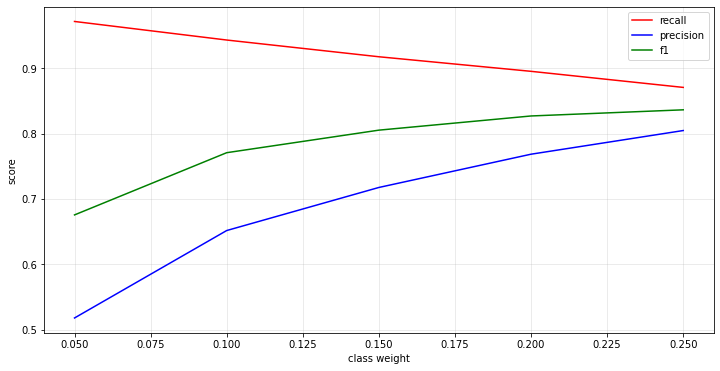

In [44]:
tune_threshold()

0.05
0.1
0.15000000000000002
0.2
0.25


{'class_weight': [0.05, 0.1, 0.15000000000000002, 0.2, 0.25],
 'accuracy': [0.4793, 0.7922, 0.8611, 0.887, 0.8978],
 'precision': [0.311, 0.5335, 0.6454, 0.7151, 0.7608],
 'recall': [0.9913, 0.956, 0.9138, 0.8669, 0.8277],
 'f1': [0.4735, 0.6848, 0.7565, 0.7837, 0.7928],
 'time': [0.3, 0.3, 0.2, 0.2, 0.2]}

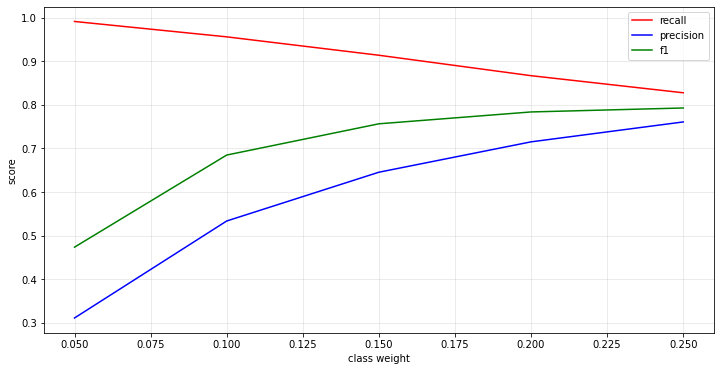

In [45]:
tune_threshold(C=0.25)

0.05
0.1
0.15000000000000002
0.2
0.25


{'class_weight': [0.05, 0.1, 0.15000000000000002, 0.2, 0.25],
 'accuracy': [0.6751, 0.8376, 0.8813, 0.8999, 0.909],
 'precision': [0.4198, 0.5984, 0.6864, 0.742, 0.7821],
 'recall': [0.9834, 0.9502, 0.9163, 0.8836, 0.852],
 'f1': [0.5884, 0.7343, 0.7848, 0.8066, 0.8155],
 'time': [0.4, 0.4, 0.3, 0.3, 0.3]}

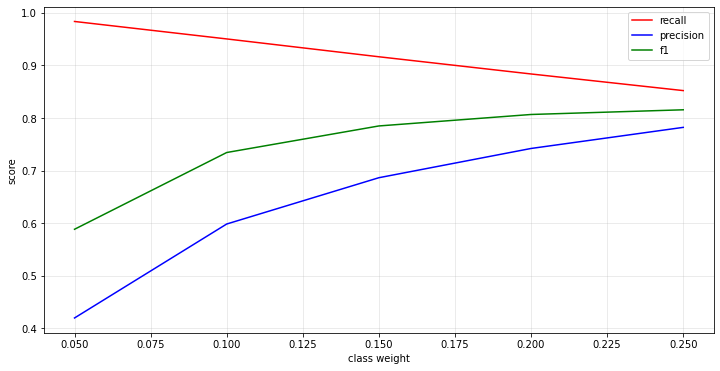

In [46]:
tune_threshold(C=0.5)

0.05
0.1
0.15000000000000002
0.2
0.25


{'class_weight': [0.05, 0.1, 0.15000000000000002, 0.2, 0.25],
 'accuracy': [0.7449, 0.8566, 0.8886, 0.9065, 0.9152],
 'precision': [0.4803, 0.6308, 0.7024, 0.7564, 0.7944],
 'recall': [0.9776, 0.9475, 0.9164, 0.891, 0.8646],
 'f1': [0.6442, 0.7573, 0.7952, 0.8182, 0.828],
 'time': [0.5, 0.4, 0.4, 0.4, 0.5]}

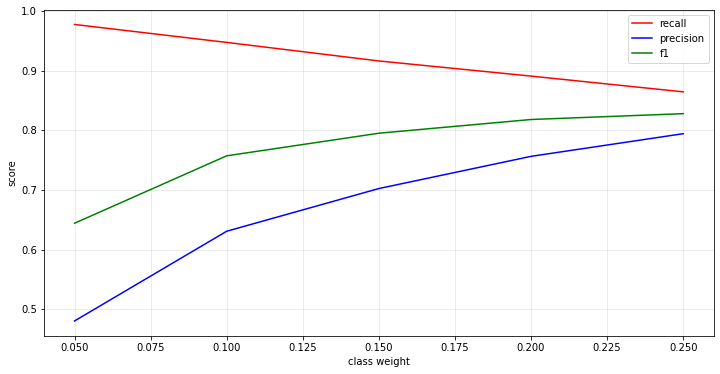

In [47]:
tune_threshold(C=0.75)

# ESTE ES EL MODELO QUE VAMOS A USAR

In [54]:
vectorizer = TfidfVectorizer(min_df=10,max_df=0.8,max_features=25000, ngram_range=(1,2),)

# make a list of models
model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),
                               n_estimators=10)

In [55]:
X_train_vec=vectorizer.fit_transform(X_train)
X_test_vec=vectorizer.transform(X_test)

In [56]:
X_train

629             mkr the sassy girls having a blonde moment
26870    in my school the pe teachers were mostly paedo...
16783    muslims ain t terrorist but b cos of an openin...
86       rt ohsosoftley some of you people will call me...
20290    danielzklein everytime he tells me about how q...
                               ...                        
27362    i m an anomaly because i m a lesbian and came ...
38611    http via me pvezng rt cleon tayyoung fuck obam...
17618    if i remember correctly muslims once ruled ove...
39821    xbonetourneys gatz games why cant i v dumb nig...
37362    lmaoo rt goats cup bet you ve sucked hella nig...
Name: text, Length: 29712, dtype: object

In [57]:
X_train_vec

<29712x12707 sparse matrix of type '<class 'numpy.float64'>'
	with 850159 stored elements in Compressed Sparse Row format>

In [58]:
cv_results = cross_validate(model, X_train_vec, y_train, cv=5, n_jobs=-1)
cv_results

{'fit_time': array([6.77784371, 6.73743248, 6.86702442, 6.84224844, 3.45750809]),
 'score_time': array([0.04635286, 0.06123567, 0.03454041, 0.03667164, 0.04328394]),
 'test_score': array([0.8520949 , 0.85243143, 0.84230899, 0.84870414, 0.84786267])}

In [59]:
model.fit(X_train_vec,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [60]:
prediction_test=model.predict(X_test_vec)
prediction_test

array([1, 0, 0, ..., 4, 0, 0])

In [66]:
print(classification_report(y_test, prediction_test, target_names=label_enc.classes_))

                     precision    recall  f1-score   support

                age       0.99      0.98      0.98      2446
          ethnicity       0.90      0.79      0.85      2968
             gender       0.91      0.77      0.84      2597
other_cyberbullying       0.67      0.91      0.77      2339
           religion       0.86      0.85      0.85      2385

           accuracy                           0.86     12735
          macro avg       0.87      0.86      0.86     12735
       weighted avg       0.87      0.86      0.86     12735



In [74]:
text=df_sample.iloc[1500]
text

text              rt underyourporch did celine just make an elep...
target                                                       gender
encoded_target                                                    2
Name: 1578, dtype: object

In [75]:
text['text']

'rt underyourporch did celine just make an elephant joke girl your making it too easy mkr'

In [76]:
text_vec=vectorizer.transform([text['text']])
prediction=class_labels[model.predict(text_vec)]
prediction[0]

'gender'

In [65]:
df_sample[['text','target']]

,text,target
29372,it s so freaking embarrassing that the preside...,age
12887,i am salafi yrs i taken ilm from spubs don t e...,religion
21829,what i took from all of this is that wadhwa do...,other_cyberbullying
40140,yourhighaj kursory momozoned hahahaha fuck you...,ethnicity
32750,like a tiny portion of dudes ever experience t...,age
...,...,...
41993,my brother get the fuck on my nerves dumb as n...,ethnicity
32103,transphobes get the bullet transphobic bullies...,age
30403,damn dude you really seem to dislike ghost of ...,age
21243,dylanw also totes constructive mention there i...,other_cyberbullying


In [87]:
preprocessing = make_column_transformer(
    (make_pipeline(vectorizer), 'text')
)


pipe = make_pipeline(
    preprocessing,
    model
)

pipe

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline',
                                                  Pipeline(memory=None,
                                                           steps=[('tfidfvectorizer',
                                                                   TfidfVectorizer(analyzer='word',
                                                                                   binary=False,
                                                                                   decode_error='strict',
                                                                                   dtype=<class 'numpy.float64'>,
                                                                                   encoding='utf-8',
                  